---
title: Linear Convection with JAX - Part III
suptitle: Time Steppers with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

> In the previous tutorial, we broke up all of the pieces into abstract concepts. We also looked at how to jax-ify all the things by creating functions for all of the bits and pieces; ranging from the domain definition to the stepper. In this tutorial, we will repeat the same procedure but define some `pytree` objects which we will operator. Many times, we need more than just the array values. There is a lot of auxillary information including stuff about the domain.


In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import kernex as kex
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recall: PDE - 1D Linear Convection

Let's continue from the previous tutorial. Recall, we are working with a 1D Linear Convection scheme:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$ (pde)

For the PDE {eq}`pde`, we are going to do a backwards difference discretization in space and a forwards in time. It is given by:

$$
u_{i}^{n+1} = u_{i}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (discretization_full)

## Recall: Jaxified Implementation

In the previous tutorial, we showed how to break this PDE into individual parts via *functions*. We identified the following parts and functions:

* Spatial Domain Definitions
* Temporal Domain Definitions
* Initial Condition Function
* Boundary Condition Function
* Right Hand Side (RHS)
* Step Function

I will go through each of these functions along with the notation we will use throughout this tutorial.

### Spatial Domain

We define our spatial discretization as:

$$
x \in \Omega \sub \mathbb{R}^{D}
$$ (spatial_d)

Where:

* $\mathbb{R}^D$ - the space of coordinates, e.g. Euclidean, Spherical, and the size, e.g. scalar, vector, etc
* $\Omega$ - the domain and discretization

For this problem our domain bounds are $[0.0, 2.0]$ and our time step is $\Delta x\sim 0.04$.


In [3]:
from jaxsw._src.domain.base import Domain

There are a few ways to initialize the domain. Here are a few:

* Define the number of values and the step
* Define the start/end points and the number of values


In [4]:
# domain params
xmin = 0.0
xmax = 2.0
dx = 0.1

# define domain object
domain = Domain(xmin=(xmin,), xmax=(xmax,), dx=(dx,))

assert domain.ndim == 1

# alternative way
xmin = 0.0
xmax = 2.0
nx = 21


domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(nx,))
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (21,)
nDims: 1
Grid Size: (21, 1)
Cell Volume: 0.1


In [5]:
domain.grid.shape

(21, 1)

In [6]:
# create grid
x_grid = Domain(xmin=(xmin,), xmax=(xmax,), dx=(dx,)).grid
x_grid_ = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(nx,)).grid

# check grids are the same
np.testing.assert_array_equal(x_grid, x_grid_)

### Demo 2D

In [7]:
# 2D DEMO!

# domain params
xmin = (0.0, 0.0)
xmax = (2.0, 10.0)
dx = (0.1, 0.5)

# define domain object
domain = Domain(xmin=xmin, xmax=xmax, dx=dx)
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

assert len(domain.coords) == 2
assert domain.coords[0].shape == domain.coords[1].shape == (21,)
assert domain.grid.shape == (21, 21, 2)


# ALTERNATIVE WAY
# domain params
xmin = (0.0, 0.0)
xmax = (2.0, 10.0)
nx = (21, 21)

# define domain object
domain = Domain.from_numpoints(xmin=xmin, xmax=xmax, N=nx)

assert len(domain.coords) == 2
assert domain.coords[0].shape == domain.coords[1].shape == (21,)
assert domain.grid.shape == (21, 21, 2)

Size: (21, 21)
nDims: 2
Grid Size: (21, 21, 2)
Cell Volume: 0.05


In [8]:
# # temporal discretization
# t0 = 0.0
# tmax = 0.5

# # CFL condition
# def cfl_cond(dx, c, sigma):
#     assert sigma <= 1.0
#     return (sigma * dx) / c

# # temporal parameters
# c = 1.0
# sigma = 0.2
# dt = cfl_cond(dx=dx, c=c, sigma=sigma)

# time_steps = np.arange(t0, tmax, dt)

### Initial Condition

We said that the initial condition is actually a function which operates on a discretized domain $\Omega$.


$$
\mathcal{IC}[u](x,0) = 
\begin{cases}
2 & \text{where } 0.5 \leq x \leq 1,\\
1 & \text{everywhere else in } (0,2) \\
\end{cases}
$$ (ic)

In practical terms, we need to initialize our state, $u$, based on the domain and discretization, $\Omega$.

$$
\mathcal{IC}[u](x,0):= \boldsymbol{IC}(\Omega, x)
$$ (ic_practical)

In [9]:
# initialize field to be zero
# alternative way
xmin = 0.0
xmax = 2.0
nx = 21


domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(nx,))

def init_u_fn(grid: Float[Array, "D 1"], dx: float) -> Float[Array, "D 1"]:
    """Initial condition from grid"""
    u = jnp.ones_like(grid, dtype=jnp.float64)
    
    u = u.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
    
    return u

In [10]:
u_init = init_u_fn(domain.grid, domain.dx[0])
u_init.shape

2023-03-14 16:20:47.547255: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


(21, 1)

## Field

In [11]:
import typing as tp
import equinox as eqx
from jaxtyping import Float
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field

## Initialization

In [12]:
# initialize field directly
u = Field(u_init, domain)
u2 = Field(u_init, domain)

### Elementary Operations

`+,-,x,div`

In [13]:

def init_u_fn(grid, dx) -> Float[Array, "D"]:
    """Initial condition from grid"""
    u = jnp.ones_like(grid, dtype=jnp.float64)
        
    u = u.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
    
    return u

In [14]:


u_init = init_u_fn(domain.grid, domain.dx[0])

### Boundary Conditions

For the boundary conditions, this is another function that is dependent upon the domain and discretization. It can be defined as:

$$
\mathcal{BC}[u](x, t) = 1.0, \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)


In practical terms, we want to apply some function, $\boldsymbol{b}$, which modifies our state, $u$, at the coordinates along the boundaries of the domain, i.e. $x \in \partial\Omega$. In our case it is constant. But we can easily think of strategies where it is an actual function.

In [15]:
def f(u: Float[Array, "D"]) -> Float[Array, "D"]:
    
    u = u.at[0].set(1.0)
    
    u = u.at[-1].set(1.0)
    
    # TODO: can use where based on points
    return u


In [16]:
from typing import Callable

class BC(eqx.Module):
    f: Callable = eqx.static_field()
    
    def __init__(self, f):
        self.f = f
        
    def __call__(self, u: Field) -> Field:
        
        u = eqx.tree_at(lambda x: x.values, u, self.f(u.values))
        
        return u

In [17]:
bc_fn = BC(f)

In [18]:
u_out = bc_fn(u)

2023-03-14 16:20:52.189767: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


### Differential Operators

We identified the differential operators, $\mathcal{N}[\cdot;\boldsymbol{\theta}]$ on the RHS of the equation. In this case, we used the backwards time finite difference method because this is a convection scheme. There are (hyper)-parameters, $\boldsymbol{\theta}$, in every differential operator because there are possibly (ad-hoc) decisions that one must make for all discretizations, e.g. finite difference schem (backwards, forwards, central) and stencil order. 

The 1st order backwards difference is defined as:

$$
\mathcal{N}_{BD}[u] = \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (bd)

We showcased how we can use the stencil operator as a way to handle finite differences instead of the messy slicing operations. (Tutorial on this soon!)

In [19]:
from jaxsw._src.operators.fd import Difference
from jaxsw._src.operators.constant import Constant
    

In [48]:
f_du_dx = Difference(u.domain, axis=0, method="central", accuracy=2)


du_dx = f_du_dx(u)

In [49]:
# CFL Conditions
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c


c = 1.0
sigma = 0.2
dt = cfl_cond(dx=domain.dx[0], c=c, sigma=sigma)

constant = Constant(u.domain, constant=-c)

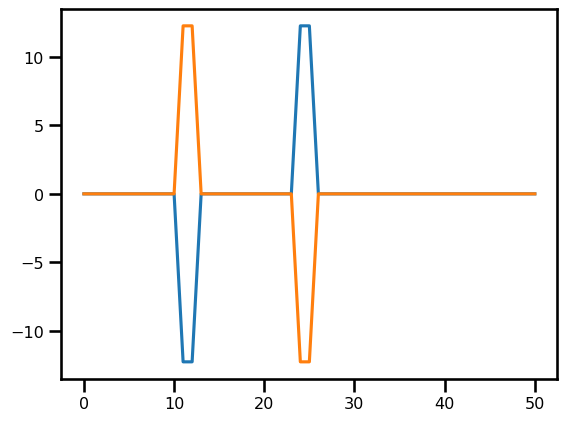

In [50]:
fig, ax = plt.subplots()

ax.plot(-c*du_dx[...,0])
ax.plot(du_dx[...,0])
plt.show()


### Right Hand Side

Now, this is the ultimate part that glues the differential operators and the boundary conditions together.

$$
\begin{aligned}
\mathcal{F}[u] &= - c \cdot \mathcal{N}_\text{BackDiff}[u;\boldsymbol{\theta}](x) \hspace{10mm} x\in\Omega
\end{aligned}
$$ (rhs_complete)

We dump all of this within the function to define our RHS function.

In [51]:
# RHS function
def rhs_fn(u: Float[Array, "D"], c: PyTree[float]) -> Float[Array, "D"]:
    """RHS for 1D Advection. 
    Uses a Backwards FD scheme
    """
    
    # FD
    u = f_du_dx(u)
    
    # constant
    u = eqx.tree_at(lambda x: x.values, u, - c * u.values)
    
    return u

## Time Stepping

So in the previous tutorial, we talked about the step function but let's pause for a moment and rethink. The step function is actually a combination of two things:

1. The RHS which includes the spatial derivatives.
2. The time stepping scheme

We have already taken care of the spatial derivatives in the previous step. So looking again at equations {eq}`pde` and {eq}`discretization_full`, we write the half step in between them.

$$
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (pde_spatial_discretization)

where we have the RHS as defined in equation {eq}`rhs_complete` but we *did not* write the time stepping scheme for Euler. Instead, we're going to offset this to another library called `diffrax`.

### Temporal Domain

We define our temporal discretization as:

$$
t \in \mathcal{T} \sub \mathbb{R}^+
$$ (time_d)

where the space time coordinates are bounded by $\mathcal{T}=[0,T]$. For our problem, it is bounded between $[0.0, 0.5]$. Recall, the time step was calculated from the CFL condition given by

$$
\Delta t = \frac{\sigma\Delta x}{c} \leq 1
$$ (cfl_advection_dt)



In [52]:
# temporal discretization
t0 = 0.0
tmax = 0.5

# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=domain.dx[0], c=c, sigma=sigma)

time_steps = np.arange(t0, tmax, dt)

## Simple Example: ODEs


Recall our favourite initial value problem (IVP) with the ODE formulation

$$
\dot{y}(t) = f(y(t), t)
$$ (ode)

where the solution is given by the fundamental theorem of calculus as

$$
y(t) = y(0) + \int_{t_0}^{t} f(y(\tau),\tau)d\tau
$$

So as an example, let's say my function, $f$, is given by:

$$
f(t) = -y
$$ (ode_fn)

which is a very easy example.

## Back to PDEs

Our problem is a time-dependent PDE. We actually did the method of lines (MOL) to solve it. We broke down the spatial derivative and offsetted everything to the RHS without writing the derivative. Now if we use the fundamental theorem of calculus like the ODE problem, we get:

$$
\begin{aligned}
u_{t} &= u(0) + \int_{0}^{t} f(u(\tau),\tau)d\tau \\
f(u(\tau),\tau) &:= \mathcal{RHS}[u](x,\tau) 
\end{aligned}
$$

whereby we solve this using the MOL. Essentially we solve a series of ODEs.

```{note}
For elliptical PDEs, the MOL is not so straightforward because of the higher order derivatives. So I've heard names like the MOL for transient PDEs.
```

In [123]:
f_du_dx = Difference(u.domain, axis=0, accuracy=1, method="backward")

# RHS function
def rhs_fn(u: Float[Array, "D"], c: PyTree[float]) -> Float[Array, "D"]:
    """RHS for 1D Advection. 
    Uses a Backwards FD scheme
    """
    
    # FD
    u = f_du_dx(u)
    
    # constant
    u = eqx.tree_at(lambda x: x.values, u, - c * u.values)
    
    return u

In [124]:
from tqdm.notebook import tqdm

def vector_field(t, u, args):
    
    # apply bcs
    u = bc_fn(u)
    
    # calculate RHS
    u = rhs_fn(u, c)
    
    return u


In [125]:
u

Field(
  values=f64[51,1],
  domain=Domain(xmin=(0.0,), xmax=(2.0,), dx=(0.04081632653061224,))
)

In [126]:
vector_field(0, u, None)

Field(
  values=f64[51,1],
  domain=Domain(xmin=(0.0,), xmax=(2.0,), dx=(0.04081632653061224,))
)

In [127]:
domain.size

(51,)

In [128]:
import diffrax

# domain params
xmin = 0.0
xmax = 2.0
N = 50
dx = xmax / (N - 1)

# define domain object
# domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(N,))
domain = Domain(xmin=(xmin,), xmax=(xmax,), dx=(dx,))

u_init = init_u_fn(domain.grid, domain.dx[0])

u = Field(u_init, domain)

# TEMPORAL DISCRETIZATION
t0 = 0.0
tmax = 0.5

# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)
# dt = 0.0001



# define ODE
term = diffrax.ODETerm(vector_field)

# TEMPORAL DISCRETIZATION
ts = jnp.linspace(t0, tmax, 50)
saveat = diffrax.SaveAt(ts=ts)

solver = diffrax.Euler()
# solver = diffrax.ImplicitEuler()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    tmax,
    dt,
    u,
    saveat=saveat,
    max_steps=None,
)





In [129]:
dt

0.008163265306122448

In [130]:
X, Y = np.meshgrid(u.domain.grid, ts)
X.shape, Y.shape, sol.ys.values.shape

((50, 51), (50, 51), (50, 51, 1))

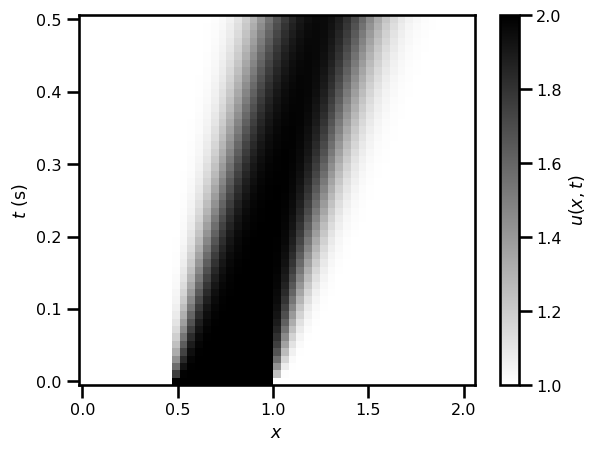

In [131]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(X, Y, sol.ys.values.squeeze(), cmap="gray_r")
plt.colorbar(pts, label=r"$u(x,t)$")
ax.set(
    xlabel=r"$x$", ylabel=r"$t$ (s)"
)

plt.show()

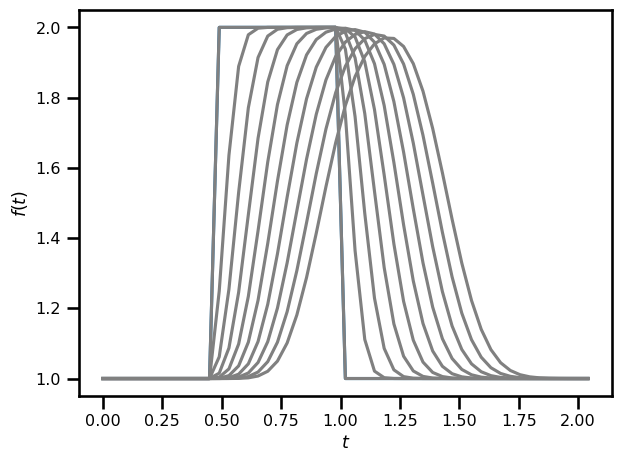

In [132]:
fig, ax = plt.subplots()
ax.plot(u.domain.grid.squeeze(), u.values.squeeze())
ax.plot(u.domain.grid.squeeze(), sol.ys.values.squeeze().T[..., ::5], color="gray", label="Euler")
ax.set(
    xlabel="$t$",
    ylabel="$f(t)$",
)
plt.tight_layout()
plt.show()

In [ ]:
# Implicit Euler
rtol = 1e-5
atol = 1e-5
pcoeff = 0.3
icoeff = 0.4
dtmax = 0.001
solver = diffrax.ImplicitEuler(
    nonlinear_solver=diffrax.NewtonNonlinearSolver(rtol=1e-3, atol=1e-6)
)
sol_2 = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    tmax,
    dt,
    u,
    saveat=saveat,
    # stepsize_controller=stepsize_controller,
    max_steps=None,
)


In [111]:
# define ODE
term = diffrax.ODETerm(vector_field)

# TEMPORAL DISCRETIZATION
saveat = diffrax.SaveAt(ts=ts)

# TOLERANCES
rtol = 1e-5
atol = 1e-5
pcoeff = 0.3
icoeff = 0.4
dtmax = 0.001
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dtmax
)
# solver = diffrax.Dopri5()
solver = diffrax.Tsit5()
sol_2 = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    tmax,
    dt,
    u,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)


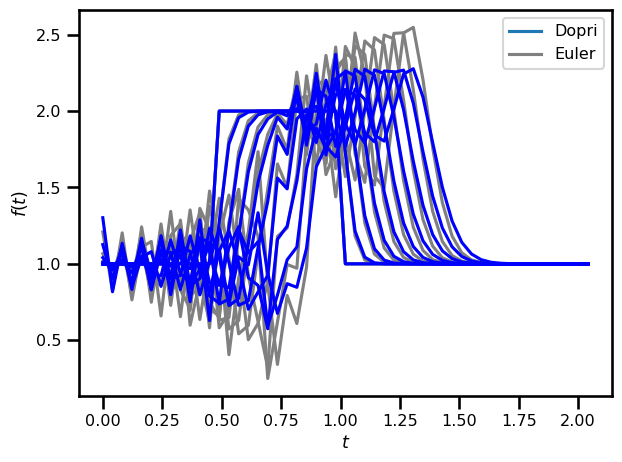

In [112]:
fig, ax = plt.subplots()
ax.plot(u.domain.grid.squeeze(), u.values.squeeze())
ax.plot(u.domain.grid.squeeze(), sol.ys.values.squeeze().T[..., ::5], color="gray", label="Euler")
ax.plot(u.domain.grid.squeeze(), sol_2.ys.values.squeeze().T[..., ::5], color="blue", label="Dopri5")
ax.set(
    xlabel="$t$",
    ylabel="$f(t)$",
)
plt.legend(["Dopri", "Euler"])
plt.tight_layout()
plt.show()

As we can see, there seems to be some dissipation. Could be the solver? Something to think about. But I think the most important thing is the fact that it is so easy to just try things without getting bogged down by the coding details!!

At least that is what I hope to convey!